## PDECO Method for KS Inversion
Please check the original paper of the PDE-Constrained Optimization method:
 <br>[Jensen Wasserman, Int J Quantum Chem. 2018;118:e25425](https://onlinelibrary.wiley.com/doi/full/10.1002/qua.25425);
 <br>[Kanungo, Zimmerman, Gavini, Nat Commun 10, 4497 (2019)](https://doi.org/10.1038)

In [1]:
from pyscf import gto
import matplotlib.pyplot as plt
import numpy as np
import n2v

import matplotlib as mpl
mpl.rcParams["font.size"] = 11
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.edgecolor"] = "#eae8e9" 

---
### Perform target calculation with Psi4. 
Store wavefunction (wfn) object

In [2]:
# Define Molecule
mol = gto.M(atom = """
                  Ne
                  """,
basis = 'cc-pvdz')

# Perform Calculation
mf = mol.KS()
mf.xc = 'scan'
mf.kernel()

# Extract data for n2v. 
da, db = mf.make_rdm1()/2, mf.make_rdm1()/2
ca, cb = mf.mo_coeff[:,:mol.nelec[0]], mf.mo_coeff[:, :mol.nelec[1]]
ea, eb = mf.mo_energy, mf.mo_energy

# Initialize inverter object. 
inv = n2v.Inverter( engine='pyscf' )

inv.set_system( mol, 'cc-pvdz', pbs='cc-pvqz' )
inv.Dt = [da, db]
inv.ct = [ca, cb]
inv.et = [ea, eb]

converged SCF energy = -128.882414403919
converged SCF energy = -128.156135758435  <S^2> = -2.6645353e-15  2S+1 = 1


PDECO is based on a very simple intuition: the better the density, the better the XC potential will be, at least in the region close enough to the exact density and exact XC potential. Based on this, a density error is defined and optimized:
$$N_{error} = \int dr|n(r) - n_{in}(r)|^2.$$
In order to optimize this, a Lagrangian is defined:
\begin{split}
&L\left[v_{KS}, \{\psi_i\}, \{\epsilon_i\}, \{p_i\}, \{\mu_i\}\right]\\
    =& \int(n(r)-n_{in}(r))^2 dr \\ 
    & + \sum_{i=1}^{N/2}\int p_i(r)(-\frac{1}{2}\nabla^2+v_{KS}(r) - \epsilon_i)\psi_i(r)dr\\
    &+\sum_{i=1}^{N/2}\mu_i(\int|\psi_i(r)|^2dr-1)
\end{split}
where where $\{p_i\}$ and $\{\mu_i\}$ are Lagrange multipliers for the constraints that $\{\psi_i\}$ are the KS orbitals of $v_{KS}$ with corresponding eigenvalue $\{\epsilon_i\}$ and that the $\{\psi_i\}$ are normalized.

The gradient of this Lagrangian with respect to $v_{XC}$ can be derived by solving the following equations in sequence:
\begin{align}
&(-\frac{1}{2}\nabla^2+v_{KS}(r))\psi_i(r) = \epsilon_i\psi_i(r),\label{equ:CONormalEquationa}\\
&\int |\psi_i(r)|^2 dr= 1,\\
&(-\frac{1}{2}\nabla^2+v_{KS}(r) - \epsilon_i)p_i(r)= 8(n\in(r)-n(r))\psi_i(r) - 2\mu_i\psi_i(r),\\
&\int p_i(r)\psi_i(r)dr = 0,\\
&\frac{\delta L}{\delta v_{KS}(r)}=\sum_{i=1}^{N/2}p_i(r)\psi_i(r).
\end{align}
It should be noted that, clearly $p_i$ is orthogonal to $\psi_i$ and that $(-\frac{1}{2}\nabla^2+v_{KS}(r) - \epsilon_i)$ is singular. The current implementation of n2v can produce problems here for some systems because of the linear solver used as well as the finite basis set for representing $\{p_i\}.$

---
### Invert! 
$$v_{Kohn-Sham}=v_{ext}+v_{guide}+v_{rest}$$
With the guide potential $v_{guide}=v_{Fermi-Amaldi}$ and the rest potential $v_{rest}$ on the potential basis set (pbs) "aug-cc-pvqz".

In [3]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
inv.v_pbs = np.zeros_like(inv.v_pbs)
inv.invert("PDECO", opt_max_iter=200, guide_components="fermi_amaldi", gtol=1e-6)

converged SCF energy = -128.449977324734
Optimization Successful within 26 iterations! |grad|=2.03e-05.


---

### Visualization of the potentials. 
#### Since this is a 1-D system, let's first plot it alone x axis.

In [4]:
# Build Grid
inv.eng.grid.build_rectangular((1001,1,1))
x = inv.eng.grid.x

Get exchange-correlation potentials.
\begin{align}
v_{xc}
&=v_{Kohn-Sham}-v_{Hartree}-v_{ext}\\
&=v_{guide}+v_{rest}-v_{Hartree}
\end{align}

In [7]:
vrest = inv.eng.grid.to_grid(inv.v_pbs, grid='rectangular')

In [9]:
# Get Hartree and Fermi-Amaldi potentials

vH = inv.eng.grid.hartree(density=da+db, grid='rectangular')
vFA = (1-1/(inv.nalpha + inv.nbeta)) * vH

# Build Vxc
vxc = vFA + vrest - vH

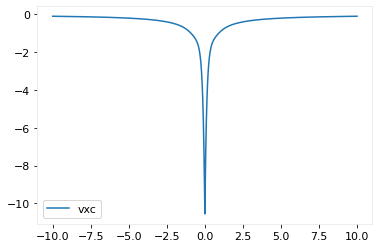

In [10]:
fig, ax = plt.subplots()
ax.plot(x, vxc, label='vxc')
ax.legend()

---
# Unrestricted Calculation 

In [11]:
# Initialize inverter object. 
inv = n2v.Inverter( engine='pyscf' )

inv.set_system( mol, 'cc-pvdz', pbs='cc-pvqz', ref=2 )
inv.Dt = [da, db]
inv.ct = [ca, cb]
inv.et = [ea, eb]

converged SCF energy = -128.156135758435  <S^2> = -2.6645353e-15  2S+1 = 1


In [14]:
# Inverter with WuYang method, guide potention v0=Fermi-Amaldi
inv.v_pbs = np.zeros_like(inv.v_pbs)
inv.invert("PDECO", opt_max_iter=200, guide_components="fermi_amaldi", gtol=1e-6)

converged SCF energy = -128.449977324734
Optimization Successful within 23 iterations! |grad|=7.05e-05.


In [18]:
# Build Grid
inv.eng.grid.build_rectangular((1001,1,1))
x = inv.eng.grid.x

vH = inv.eng.grid.hartree(density=da+db, grid='rectangular')
vFA = (1-1/(inv.nalpha + inv.nbeta)) * vH

In [22]:
vrest_a = inv.eng.grid.to_grid(inv.v_pbs[:inv.npbs], grid='rectangular')
vxc_a = vFA + vrest_a - vH

In [24]:
vrest_b = inv.eng.grid.to_grid(inv.v_pbs[inv.npbs:], grid='rectangular')
vxc_b = vFA + vrest_b - vH

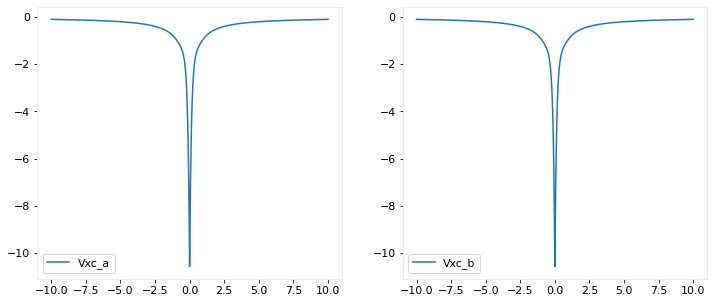

In [25]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(x, vxc_a, label='Vxc_a')
ax[1].plot(x, vxc_b, label='Vxc_b')
ax[0].legend()
ax[1].legend()